In [1]:
# Importing libraries and functions
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import pySPM
import cv2
from scipy.optimize import minimize

In [2]:
# Function for finding index nearest to given value in an array
def fn(array,values):
    """
    Finds the index where an array is nearest to a given value
    Returns an array of indices if an array of values is given
    """
    array = np.array(array)
    if hasattr(values, "__len__"):
        new_values=np.empty(len(values),dtype=int)
        for i in range(len(values)):
            new_values[i]=np.abs(array-values[i]).argmin()
    else:
        new_values = np.abs(array-values).argmin()
    return new_values

In [3]:
# Some plot settings
plt.rc('xtick', top=True, labelsize=8, direction='in')
plt.rc('ytick', right=True, labelsize=8, direction='in')
plt.rc('lines', linewidth=1, markersize=3)
plt.rc('axes', labelsize=10)
plt.rc('font', size=10)
plt.rc('legend',fontsize=7)

In [4]:
# Frequency and x-y shifts in MFM data, found manually
fshifts = [0,-0.01,-0.02,-0.02,-0.022,-0.05,-0.06,-0.067,-0.073,
                  -0.074,-0.083,-0.085,-0.085,-0.135,-0.21,-0.28,-0.35,
                  -0.39,-0.4,-0.4,-0.405,-0.405,-0.405,-0.405]
xyshifts=[(-8,-1),(-9,-1),(1,-1),(0,0),(-1,0),(0,0),(0,0),(0,0),
                 (0,0),(0,0),(0,0),(0,3),(0,3),(0,3),(0,3),(0,3),(0,3),
                 (0,3),(0,3),(0,3),(0,3),(0,3),(-2,1),(7,1)]
# In our system the real field tended to overshoot the nominal fields by ~30 mT
# These fields were found by tracking the Hall voltage versus field during the
# sweeps when taking MFM images. Nominal fields are still used for labels.
real_fields=np.array([200,285,330,380,430,495,530,580,750,900,1150,1250,1280,
                      1325,1355,1380,1405,1430,1445,1450,1500,1600,2500,4000])

In [5]:
# Import data
path = "MFM_example_data\\"
filenames = [path + '\\' + x for x in os.listdir(path)]
raw_scans = [pySPM.SXM(f) for f in filenames]
fields = [f.split("_")[-1][:-6] for f in filenames]
scans=np.empty(len(raw_scans),dtype=object)
scans_fshifted=np.empty(len(raw_scans),dtype=object)
for i,raw_scan in enumerate(raw_scans):
    # Get frequency shift values of scan
    scan_to_edit=raw_scan.get_channel('Frequency_Shift').pixels
    # Subtract the mean of each scan
    scans[i]=scan_to_edit-np.mean(scan_to_edit)
    # Shift in x-y to correct for drift
    scans[i]=np.roll(scans[i],xyshifts[i][0],1)
    scans[i]=np.roll(scans[i],xyshifts[i][1],0)[10:-10,20:-20]
    # Shift in frequency to give a monotonic frequency shift of pixels
    scans_fshifted[i] = scans[i] + fshifts[i]

# Shift the entire data-set so min=-max, use 90th quantile to avoid noise problems
scans_fshifted=scans_fshifted-(np.quantile(scans_fshifted[0],0.9)+np.quantile(scans_fshifted[-1],0.1))/2

In [6]:
# Bin all scans by field (B)

# Settings for binning values by field (B)
Bmin=-0.4
Bmax=0.4
nBins=100

# Bin scan data for field uncorrected and field corrected scans
hist_corrs=[]
hist_uncorrs=[]
for i,(scan_uncorr,scan_corr) in enumerate(zip(scans_fshifted,scans)):
        field=fields[i]
        hist_corr, bin_edges = np.histogram(scan_corr.flatten(),bins=nBins,range=(Bmin,Bmax))
        hist_uncorr,  bin_edges = np.histogram(scan_uncorr.flatten(),  bins=nBins,range=(Bmin,Bmax))
        hist_corrs.append(hist_corr)
        hist_uncorrs.append(hist_uncorr)
bins = np.array([(a + b) / 2 for a, b in zip(bin_edges[:-1], bin_edges[1:])])

In [7]:
# Interactive plotting - visualise the magnetic switch
from PIL import Image
from ipywidgets import interact, interactive
# Set histogram and scan colorpalettes
cmap_scan=sns.color_palette("vlag_r", as_cmap=True)
cmap_hist=sns.diverging_palette(145, 300, s=60, as_cmap=True)

RGBA = Image.open(r"..\Python\CG017-MFM-stripes-black.png")
RGBA = RGBA.resize((472,236), Image.ANTIALIAS)

[Hbin,r] = np.genfromtxt("..\Python\CG017-RH.txt").T

def plot_func(i):
    i = int(i)
    
    fig = plt.figure(figsize=(12,6),dpi=72)
    ax = [fig.add_axes([0.65,0.55,0.25,0.35]),
          fig.add_axes([0.65,0.1,0.25,0.35]),
          fig.add_axes([0.1,0.1,0.5,0.8])]
    
    for hist_corr in hist_corrs:
        ax[0].plot(bins,hist_corr,color='0.5',linewidth=2)
    ax[0].plot(bins,hist_corrs[i],color='red',linewidth=2)
    ax[0].set_xlabel("$\Delta f$ (Hz)")
    ax[0].set_ylabel("Counts")
    ax[1].plot(Hbin*1000,r,'C0')
    ax[1].plot(-Hbin*1000,-r,'C0')
    ax[1].scatter(float(real_fields[i]),r[fn(Hbin*1000,float(real_fields[i]))],
                 facecolor='none',edgecolor='grey',s=40)
    ax[1].set_xlim(-2000,2000)
    ax[1].axvline(x=float(real_fields[i]),color='grey')
    ax[1].set_xlabel("$\mu_0 H$ (mT)")
    ax[1].set_ylabel("$R$ ($\Omega$)")
    
    im = ax[2].imshow(np.real(scans_fshifted[i]),aspect='2',vmin=Bmin,vmax=Bmax, cmap=cmap_scan)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].imshow(RGBA,aspect='2')
    ax[2].add_patch(Rectangle((20,221),73,5,edgecolor='black',facecolor='white'))
    fig.colorbar(im,ax=ax[2],label="$\Delta f$ (Hz)")
    
interactive(plot_func,i=(0,len(scans)-1,1))

interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

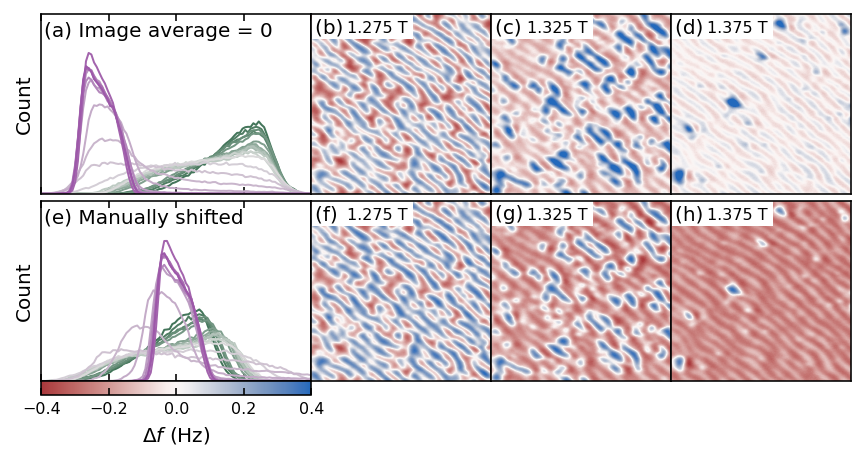

In [8]:
# Create Figure
figsize=(4.5*1.25,2*1.25)
fig=plt.figure(figsize=figsize,dpi=144)

# Create histogram axes
xsplit=1/3
ax1=fig.add_axes([0,0.52,xsplit,0.5])
ax2=fig.add_axes([0,0,xsplit,0.5])

# Set histogram and scan colorpalettes
cmap_scan=sns.color_palette("vlag_r", as_cmap=True)
cmap_hist=sns.diverging_palette(145, 300, s=60, as_cmap=True)
def darken(color,multiplier): # Darkens an RGBA colour
    return [a*multiplier if i<3 else a for i,a in enumerate(color)]

# Plot corrected and uncorrected histograms
for i,(hist_corr,hist_uncorr) in enumerate(zip(hist_corrs,hist_uncorrs)):
    ax1.plot(bins,hist_uncorr,  color=darken(cmap_hist(float(i)/len(scans)),0.9),linewidth=1)
    ax2.plot(bins,hist_corr,color=darken(cmap_hist(float(i)/len(scans)),0.9),linewidth=1)

# Histogram axis options
for ax in [ax1,ax2]:
    ax.set_ylabel("Count")
    ax.set_yticks([])
    ax.set_ylim(0,11000)
    ax.set_xlim(-0.4,0.4)
    ax.set_xticklabels([])

# Show example images for field uncorrected and field corrected scans
axs1=np.empty(3,dtype=object)
axs2=np.empty(3,dtype=object)
imgs=[13,15,17] # Which images to use in example
labels1=["(b) ","(c) ","(d) "]
labels2=["(f) ","(g) ","(h) "]
text_options={'va':'top','ha':'left','fontsize':10,'zorder':10}
ax1.text(0.01,0.96,"(a) Image average = 0",transform=ax1.transAxes,**text_options)
ax2.text(0.01,0.96,"(e) Manually shifted",transform=ax2.transAxes,**text_options)
# For each example image, create axis and plot for uncorrected and corrected version
for i in range(3):
    axs1[i]=fig.add_axes([xsplit+(1-xsplit)/3*i,0.52,(1-xsplit)/3,0.5])
    axs1[i].set_xticks([])
    axs1[i].set_yticks([])
    axs2[i]=fig.add_axes([xsplit+(1-xsplit)/3*i,0,(1-xsplit)/3,0.5])
    axs2[i].set_xticks([])
    axs2[i].set_yticks([])
    im1=axs1[i].imshow(np.real(scans[imgs[i]]),aspect='2',vmin=-0.4,vmax=0.4, cmap=cmap_scan)
    im2=axs2[i].imshow(np.real(scans_fshifted[imgs[i]]),aspect='2',vmin=-0.4,vmax=0.4, cmap=cmap_scan)
    for ax in [axs1[i],axs2[i]]:
        ax.add_patch(Rectangle((20,241),73,7,edgecolor='black',facecolor='white'))
        ax.add_patch(Rectangle((0,0),265,32,facecolor='white'))
        ax.text(0.2,0.965,str(float(fields[imgs[i]])/1000)+ " T",transform=ax.transAxes,va='top',ha='left',size=8)
    axs1[i].text(0.02,0.98,labels1[i],transform=axs1[i].transAxes,**text_options)
    axs2[i].text(0.02,0.98,labels2[i],transform=axs2[i].transAxes,**text_options)

null_ax=fig.add_axes([0,-0.15,xsplit,1])
null_ax.axis('off')
fig.colorbar(im1,ax=null_ax,label="$\Delta f$ (Hz)",location='bottom')

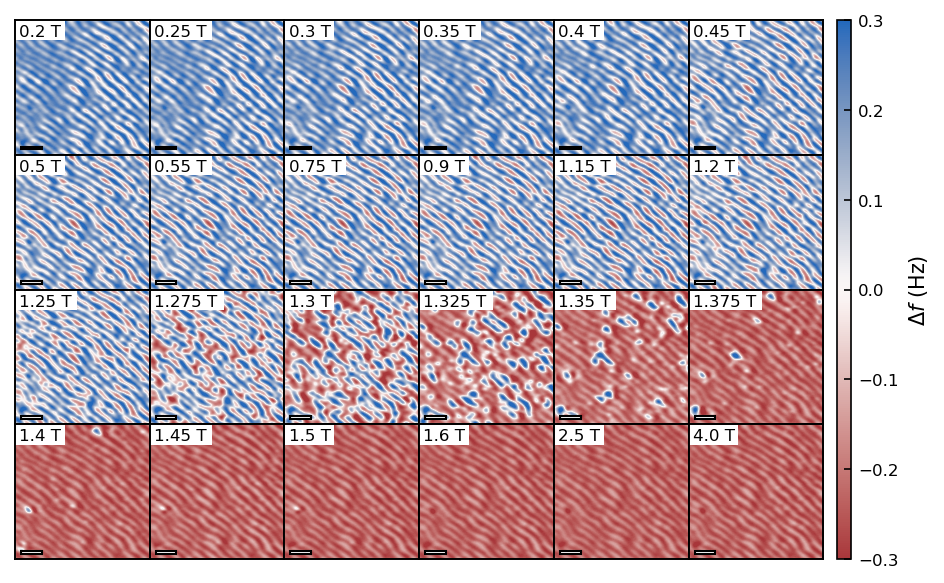

In [9]:
Bmin=-0.3
Bmax=0.3

# Creating the figure and axes
col=6
row = 4
aspect=1.67
fig = plt.figure(figsize=(6,6/aspect),dpi=150)
axes = np.empty((col,row),dtype=object)
axes2 = np.empty((col,row),dtype=object)

# The null ax is needed for the overall colorbar
# We'll define a 'mappable' object normalised to the limits we want
nullax=fig.add_axes([0,0,1.075,1])
nullax.axis('off')
cmap=sns.color_palette("vlag_r", as_cmap=True)
norm = Normalize(vmin=Bmin, vmax=Bmax)
mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
fig.colorbar(mappable, ax=nullax, label="$\Delta f$ (Hz)",aspect=40)

# Make all the individual (row x column) axes
h=1/row # ax size
for i in range(col):
    for j in range(row):
        axes[i][j]=fig.add_axes([h*i/aspect,1-h*(j+1),h/aspect,h])
        axes2[i][j]=fig.add_axes([h*i/aspect,1-h*(j+1),h/aspect,h],label='2')
        for ax in [axes[i][j],axes2[i][j]]:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor('none')
            
# For labelling the field value
labels=[str(float(field)/1000) for field in fields]

# Go through scans, plot, and label
for i in range(len(scans)):
    ax = axes[i%col][i//col]
    ax.imshow(np.real(scans_fshifted[i]),aspect='2',vmin=Bmin,vmax=Bmax, cmap=cmap)
    # Scale bar, this is 1 micron
    ax.add_patch(Rectangle((20,221),73,5,edgecolor='black',facecolor='white'))
    # The field label
    ax.add_patch(Rectangle((0,0),(len(labels[i])-1)*42+90,35,edgecolor='none',facecolor='white',zorder=2))
    ax.text(0.03,0.97,labels[i]+ " T",va='top',ha='left',transform=ax.transAxes,size=8,zorder=2.1)

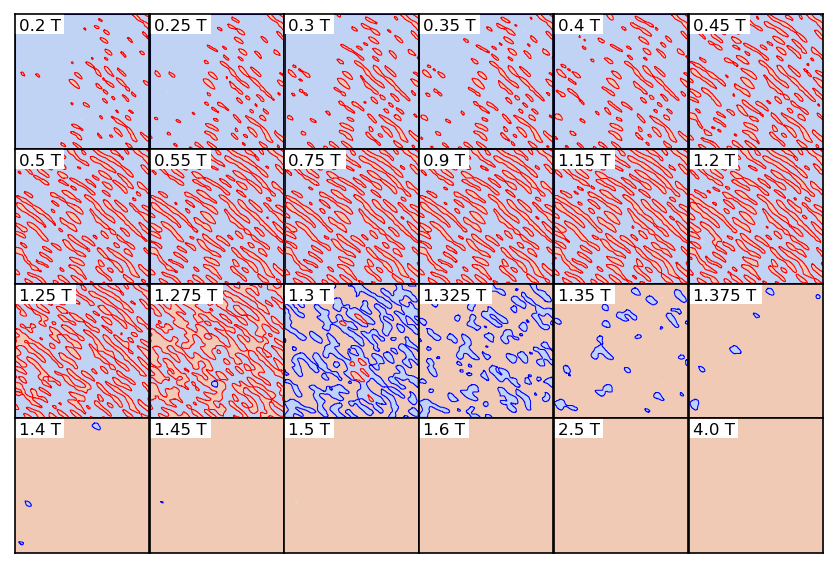

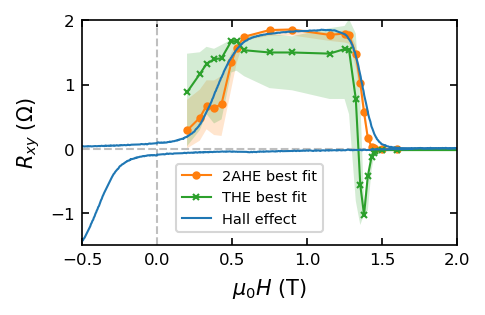

In [10]:
# Now we'll try counting the number of 'up' and 'down' domains are in our images.
# We'll take a threshold to make our images binary then use Pythons open computer 
# vision package to find, count and plot contiguous blobs.

# Creating the figure and axes
col=6
row = 4
aspect=1.67
fig = plt.figure(figsize=(6,6/aspect),dpi=150)
axes = np.empty((col,row),dtype=object)
h=1/row
for i in range(col):
    for j in range(row):
        axes[i][j]=fig.add_axes([h*i/aspect,1-h*(j+1),h/aspect,h])
        ax=axes[i][j]
        ax.set_xticks([])
        ax.set_yticks([])

# Import Hall data
[Hbin,r] = np.genfromtxt("..\Python\CG017-RH.txt").T

H=real_fields/1000

# Labels for the images
labels=[str(float(field)/1000) for field in fields]

# We'll be finding best fits for AHEs and THEs for different thresholds
# The choice of threshold value is somewhat arbitrary
# We'll try different thresholds between -0.1 and 0.1 to see how it affects fittings
nthresh=21
AHEs=np.zeros([nthresh,len(scans)])
THEs=np.zeros([nthresh,len(scans)])
for i1,threshold in enumerate(np.linspace(-0.1,0.1,nthresh)):
    
    f=np.zeros(len(scans)) #The area fraction of 'up' domains
    blobs=np.empty([len(scans),2]) #The number of up and down blobs
    
    for i2 in range(len(scans)):
        # These count the number of up and down bubbles
        n_up=0
        n_down=0
        
        # Take the threshold image - same as boolean mask
        thresh_im=scans_fshifted[i2]>threshold
        
        # Need to pad the outside of the image otherwise it doesn't count bubbles correctly
        # Try commenting these out to see why
        if np.mean(thresh_im)>0.5:
            thresh_im=np.pad(thresh_im,1,constant_values=1)
            n_down-=1 # The whole image should not count as a bubble
        else:
            thresh_im=np.pad(thresh_im,1,constant_values=0)
            n_up-=1 # The whole image should not count as a bubble
        
        # We will plot the images for threshold=0 as an example
        if i1==nthresh//2:
            ax = axes[i2%col][i2//col]
            ax.imshow(thresh_im,aspect='2',vmin=-2,vmax=3, cmap=plt.cm.coolwarm_r)
        
        # Note: 'up' domains have deltaF below 0
        # So the the 'up' area fraction is 1 - avg of threshold image
        f[i2]=1-np.mean(thresh_im[1:-2,1:-2])
        
        # Now we use the findContours function from cv2 to find the contiguous domains
        # First need to convert the image to a format used by cv2
        u8 = thresh_im.astype(np.uint8)
        # Now find contours. Using 'RETR_CCOMP' mode to distinguish between up and down domains
        _,cnts,hierachy = cv2.findContours(u8, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        
        # We go through all the contours to count and plot
        for i3,c in enumerate(cnts):
            # Only count blobs with area larger than a certain number of pixels
            if cv2.contourArea(c)>9: 
                # This hierachy value means down bubble for RETR_CCOMP mode
                if hierachy[0][i3][3]==-1:
                    n_down+=1
                else: # it is an up bubble
                    n_up+=1
                    
                if i1==nthresh//2: # for threshold=0 we plot
                    # get the x,y values for the contours
                    xy=c[:,0,:]
                    # add the first value onto the end so it loops
                    xy=np.concatenate((xy,[xy[0,:]]),0)
                    # this a one-line way to decide color based on up or down
                    color=['r','b'][int(hierachy[0][i3][3]==-1)]
                    ax.plot(xy[:,0],xy[:,1],color,linewidth=0.5,zorder=1.9)
        
        # Set the values for number of blobs in the image
        blobs[i2,:]=(n_down,n_up)
        
        # For adding labels if we are plotting
        if i1==nthresh//2:
            ax.add_patch(Rectangle((0,0),(len(labels[i2])-1)*42+90,35,
                                   edgecolor='none',facecolor='white',zorder=2))
            ax.text(0.03,0.97,labels[i2]+ " T",va='top',ha='left',
                    transform=ax.transAxes,size=8,zorder=2.1)
    
    # The THE is proportional to the number of up - number of down domains
    THE=blobs[:,0]-blobs[:,1]
    
    # The cross over idx is where we consider the first switch to end and the 
    # second to begin. I use 9 = 0.9 T which is in the middle of the transition
    crossover_idx=9
    # The AHE is proportional to the area fraction, we take everything that is
    # up at the crossover to be 4 UC i.e. AHE4, and everything after to be 5 UC
    # i.e AHE5
    AHE4=f/f[crossover_idx]
    AHE4[AHE4>1]=1
    AHE5=(f-f[crossover_idx])/(1-f[crossover_idx])
    AHE5[AHE5<0]=0
    
    # We now do a least squares regression, and weight this by the field 
    # difference between points.
    weights=np.diff(H)
    weights=np.insert(weights,[0,-1],[weights[0],weights[-1]])
    weights=np.array([(a+b)/2 for a,b in zip(weights[1:],weights[:-1])])
    # We only adjust the overall scaling in the minimization
    res=minimize(lambda x: np.sum(weights*(x*(AHE4-AHE5) - r[fn(Hbin,H)])**2), x0=1.85)
    AHEs[i1,:]=res.x*(AHE4-AHE5)
    res=minimize(lambda x: np.sum(weights*(x*THE - r[fn(Hbin,H)])**2), x0=-0.02)
    THEs[i1,:]=res.x*THE

#Now we'll plot the fits and data on a separate fig
fig2=plt.figure(figsize=(2.5,1.5),dpi=150)
ax=fig2.add_axes([0,0,1,1])
ax.axhline(color='0.75',linestyle='--')
ax.axvline(color='0.75',linestyle='--')

# We'll fill between the min and max values for each type of fit to give 
# an indication of error in fitting
ax.fill_between(H,np.min(AHEs,axis=0),np.max(AHEs,axis=0),facecolor='C1',alpha=0.2)
ax.fill_between(H,np.min(THEs,axis=0),np.max(THEs,axis=0),facecolor='C2',alpha=0.2)
# And we'll plot the AHE and THE found from threshold=0, shown in the images
ax.plot(H,AHEs[nthresh//2],'C1o-',label="2AHE best fit")
ax.plot(H,THEs[nthresh//2],'C2x-',label="THE best fit")

#Finally plot the actual measured Hall effect
ax.plot(Hbin,r,'C0',label="Hall effect")
ax.plot(-Hbin,-r,'C0')
ax.set_xlim(-0.5,2)
ax.set_ylim(-1.5,2)
ax.set_xlabel("$\mu_0 H$ (T)")
ax.set_ylabel("$R_{xy}$ ($\Omega$)")
ax.legend(loc=(0.25,0.06))